# Koopman Seq2Seq model

[work in progress]

Here I develop a new ML architecture, combining Koopman kernel methods with a seq2seq architecture.

In [ ]:
import os
import random
import time

import numpy as np
import torch
# from klearn_tcyclone.training_utils.args import FLAGS, ALL_FLAGS
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils import data

from klearn_tcyclone.climada.tc_tracks import TCTracks
from klearn_tcyclone.data_utils import (
    LinearScaler,
)
from klearn_tcyclone.KNF.modules.eval_metrics import RMSE_TCTracks
from klearn_tcyclone.KNF.modules.train_utils import (
    eval_epoch_koopman,
    train_epoch_koopman,
)
from klearn_tcyclone.knf_data_utils import TCTrackDataset
from absl import app, flags

from klearn_tcyclone.training_utils.training_utils import extend_by_default_flag_values

from klearn_tcyclone.koopkernel_seq2seq import NystroemKoopKernelSequencer, RBFKernel

from klearn_tcyclone.data_utils import (
    standardized_context_dataset_from_TCTracks,
)

from matplotlib import pyplot as plt
from klearn_tcyclone.KNF.modules.models import Koopman
import torch


from klearn_tcyclone.koopkernel_seq2seq_utils import train_KKSeq2Seq
from klearn_tcyclone.koopkernel_seq2seq_utils import plot_TCTrackDataset_item_2D_with_prediction_koopman_seq2seq
from klearn_tcyclone.plot_utils import plot_TCTrackDataset_item_2D
import logging

## Import data

Set some specific parameters and load default values for all other parameters.

In [2]:
flag_params = {
    # "seed": 42,
    "year_range": [1980, 1988],
    # "batch_size": 16,
    "num_epochs": 20,
    "train_output_length": 1,
    "test_output_length": 1,
    "input_length": 13,
    "context_length": 14,
}
flag_params = extend_by_default_flag_values(flag_params)

assert flag_params["context_length"] == flag_params["input_length"] + flag_params["train_output_length"]

In [3]:
random.seed(flag_params["seed"])  # python random generator
np.random.seed(flag_params["seed"])  # numpy random generator

torch.manual_seed(flag_params["seed"])
torch.cuda.manual_seed_all(flag_params["seed"])

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

feature_list = [
    "lon",
    "lat",
    "max_sustained_wind",
    # "radius_max_wind",
    # "radius_oci",
    "central_pressure",
    "environmental_pressure",
]

# feature_list = [
#     "lon",
#     "lat",
#     "max_sustained_wind",
#     "radius_max_wind",
#     "radius_oci",
#     "central_pressure",
#     "environmental_pressure",
# ]

# these are not contained as flags
# encoder_hidden_dim = flag_params["hidden_dim"]
# decoder_hidden_dim = flag_params["hidden_dim"]
# encoder_num_layers = flag_params["num_layers"]
# decoder_num_layers = flag_params["num_layers"]

output_dim = flag_params["input_dim"]
num_feats = len(feature_list)
learning_rate = flag_params["learning_rate"]
# ---------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device", device)

scaler = LinearScaler()

Device cuda


In [4]:
time_lag = 1
scaler = LinearScaler()
basin = "NA"

In [5]:
# Datasets
tc_tracks = TCTracks.from_ibtracs_netcdf(
    provider="official",
    year_range=flag_params["year_range"],
    basin=basin,
)

tc_tracks_train, tc_tracks_test = train_test_split(tc_tracks.data, test_size=0.1)

2025-02-22 18:39:06,802 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file /home/ecjb/climada/data/IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.
2025-02-22 18:40:48,218 - climada.hazard.tc_tracks - WARNING - 49 storm events are discarded because no valid wind/pressure values have been found: 1980199N31284, 1980200N25270, 1980204N23287, 1980226N15339, 1980238N16328, ...


/home/ecjb/packages/climada_python/climada/hazard/tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:


In [6]:
len(tc_tracks_train), tc_tracks_train[5]

(73,
 <xarray.Dataset> Size: 8kB
 Dimensions:                 (time: 134)
 Coordinates:
   * time                    (time) datetime64[ns] 1kB 1986-08-13T12:00:00 ......
     lat                     (time) float32 536B 30.1 30.45 30.8 ... 56.2 56.2
     lon                     (time) float32 536B -84.0 -84.0 -84.0 ... 7.0 8.0
 Data variables:
     radius_max_wind         (time) float32 536B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
     radius_oci              (time) float32 536B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
     max_sustained_wind      (time) float32 536B 10.0 10.0 10.0 ... 15.0 15.0
     central_pressure        (time) float32 536B 1.009e+03 1.01e+03 ... 1.006e+03
     environmental_pressure  (time) float64 1kB 1.01e+03 1.01e+03 ... 1.01e+03
     time_step               (time) float64 1kB 3.0 3.0 3.0 3.0 ... 3.0 3.0 3.0
     basin                   (time) <U2 1kB 'NA' 'NA' 'NA' ... 'NA' 'NA' 'NA'
 Attributes:
     max_sustained_wind_unit:  kn
     central_pressure_unit:    mb
     orig_event

The idea is to feed the tensor_context_dataset into the model. Because for the kernels I need the lookback window and the shifted version of this.

In [7]:
tensor_context_train_standardized = standardized_context_dataset_from_TCTracks(
    tc_tracks_train,
    feature_list=feature_list,
    scaler=scaler,
    context_length=flag_params["context_length"],
    time_lag=time_lag,
    fit=True,
    periodic_shift=True,
    basin=basin,
)

con_len set to context_length.


In [8]:
tensor_context_train_standardized.shape

(3301, 14, 5)

In [9]:
train_set = TCTrackDataset(
    input_length=flag_params["input_length"],
    output_length=flag_params["train_output_length"],
    tc_tracks=tc_tracks_train,
    feature_list=feature_list,
    mode="train",
    jumps=flag_params["jumps"],
    scaler=scaler,
    fit=True,
)
valid_set = TCTrackDataset(
    input_length=flag_params["input_length"],
    output_length=flag_params["train_output_length"],
    tc_tracks=tc_tracks_train,
    feature_list=feature_list,
    mode="valid",
    jumps=flag_params["jumps"],
    scaler=scaler,
    fit=False,
)
test_set = TCTrackDataset(
    input_length=flag_params["input_length"],
    output_length=flag_params["test_output_length"],
    tc_tracks=tc_tracks_test,
    feature_list=feature_list,
    mode="test",
    # jumps=flag_params["jumps"], # jumps not used in test mode
    scaler=scaler,
    fit=False,
)
train_loader = data.DataLoader(
    train_set, batch_size=flag_params["batch_size"], shuffle=True, num_workers=1
)
valid_loader = data.DataLoader(
    valid_set, batch_size=flag_params["batch_size"], shuffle=True, num_workers=1
)
test_loader = data.DataLoader(
    test_set, batch_size=flag_params["batch_size"], shuffle=False, num_workers=1
)

if len(train_loader) == 0:
    raise Exception(
        "There are likely too few data points in the test set. Try to increase year_range."
    )

In [10]:
#TODO Check why we have nan values!

### Single step model

In [11]:
# flag_params["koopman_kernel_num_centers"] = 200
flag_params["koopman_kernel_num_centers"] = 1000

In [ ]:
# rbf = RBFKernel(length_scale=1E-1)

# #TODO some parameters don't play a role in model definition -> remove them
# koopkernelmodel = NystroemKoopKernelSequencer(
#     kernel=rbf,
#     input_dim = num_feats,
#     input_length = 13,
#     output_length = 1,
#     output_dim = 1,
#     num_steps = 1,
#     num_nys_centers = flag_params["koopman_kernel_num_centers"],
#     rng_seed = 42,
#     # context_mode="last_context"
#     # context_mode="no_context"
#     context_mode="full_context"
# )

# koopkernelmodel._initialize_nystrom_data(tensor_context_train_standardized)

#### Compare context modes

In [3]:
# Logging and define save paths
# current_file_dir_path = os.path.dirname(os.path.abspath(__file__))
current_file_dir_path = os.getcwd()
results_dir = os.path.join(
    current_file_dir_path,
    "training_results",
    "{}_yrange{}_basin{}".format(
        flag_params["dataset"],
        "".join(map(str, flag_params["year_range"])),
        flag_params["basin"],
    ),
    flag_params["model"],
)
logs_dir = os.path.join(
    current_file_dir_path,
    "logs",
    # flag_params["dataset"],
    "{}_yrange{}".format(
        flag_params["dataset"],
        "".join(map(str, flag_params["year_range"])),
    ),
)
os.makedirs(results_dir, exist_ok=True)
os.makedirs(logs_dir, exist_ok=True)
logging.basicConfig(
    filename=os.path.join(logs_dir, flag_params["model"] + "_testrun.log"),
    encoding="utf-8",
    filemode="a",
    format="{asctime} - {name} - {filename}:{lineno} - {levelname} - {message}",
    style="{",
    datefmt="%Y-%m-%d %H:%M:%S",
    force=True,
)
logger = logging.getLogger(flag_params["model"] + "_logger")
logger.info(flag_params)

NameError: name 'flag_params' is not defined

In [15]:
model_name=flag_params["model"] + "_testrun"
results_file_name = os.path.join(results_dir, model_name)

eval_metric = RMSE_TCTracks
scaler = LinearScaler()

In [17]:
flag_params["koopman_kernel_num_centers"]

1000

In [18]:
flag_params

{'year_range': [1980, 1988],
 'num_epochs': 20,
 'train_output_length': 1,
 'test_output_length': 1,
 'input_length': 13,
 'context_length': 14,
 'seed': 123,
 'model': 'KNF',
 'dataset': 'TCTracks',
 'basin': 'EP',
 'time_step_h': 1.0,
 'global_local_combination': 'additive',
 'learning_rate': 0.001,
 'decay_rate': 0.9,
 'batch_size': 32,
 'min_epochs': 10,
 'data_dir': 'data_prep/M4/',
 'regularize_rank': False,
 'use_revin': True,
 'use_instancenorm': False,
 'add_global_operator': True,
 'add_control': True,
 'data_freq': 'None',
 'dropout_rate': 0.0,
 'latent_dim': 32,
 'num_steps': 5,
 'control_hidden_dim': 64,
 'num_layers': 4,
 'control_num_layers': 3,
 'jumps': 5,
 'input_dim': 7,
 'hidden_dim': 128,
 'num_heads': 1,
 'transformer_dim': 64,
 'transformer_num_layers': 3,
 'num_sins': -1,
 'num_poly': -1,
 'num_exp': -1,
 'time_lag': 1,
 'tikhonov_reg': 1e-08,
 'koopman_kernel_rank': 25,
 'koopman_kernel_reduced_rank': True,
 'koopman_kernel_num_centers': 1000,
 'koopman_kernel_

In [ ]:
# flag_params["seed"] = 42

In [ ]:
rbf = RBFKernel(length_scale=1E-1)

context_modes = [
    # "no_context",
    "full_context",
    # "last_context",
]
models = {}
train_losses = {}
train_losses2 = {}
for cm in context_modes:


    #TODO some parameters don't play a role in model definition -> remove them
    koopkernelmodel = NystroemKoopKernelSequencer(
        kernel=rbf,
        input_dim = num_feats,
        input_length = flag_params["input_length"],
        output_length = flag_params["train_output_length"],
        output_dim = 1,
        num_steps = 1,
        num_nys_centers = flag_params["koopman_kernel_num_centers"],
        rng_seed = 42,
        context_mode=cm,
    )

    koopkernelmodel._initialize_nystrom_data(tensor_context_train_standardized)

    m, tl = train_KKSeq2Seq(
        model=koopkernelmodel,
        eval_metric=eval_metric,
        tc_tracks=tc_tracks,
        num_epochs=flag_params["num_epochs"],
        batch_size=flag_params["batch_size"],
        feature_list=feature_list,
        scaler=scaler,
        basin=basin,
        logger=logger,
        results_dir=results_dir,
        model_name=model_name,
        flag_params=flag_params,
        results_file_name=results_file_name,
        split_valid_set = False,
    )

    models[cm] = m
    train_losses[cm] = tl
    train_losses2[cm] = tl2

intput_length and output_length are not None.
intput_length and output_length are not None.
intput_length and output_length are not None.
intput_length and output_length are not None.
  batch 10 loss: 0.2871760159730911
  batch 20 loss: 0.20240771323442458
  batch 30 loss: 0.18928464353084565
  batch 40 loss: 0.16070977598428726
  batch 50 loss: 0.1277884840965271
  batch 60 loss: 0.1033817209303379
  batch 70 loss: 0.11382858827710152
  batch 80 loss: 0.11373460143804551
  batch 90 loss: 0.16366182565689086
  batch 100 loss: 0.1090022549033165
eval comparison 0.4033054667735527 1000000.0
  batch 10 loss: 0.10681212395429611
  batch 20 loss: 0.09611892960965633
  batch 30 loss: 0.08358255438506604
  batch 40 loss: 0.06998603157699108
  batch 50 loss: 0.060283456742763517
  batch 60 loss: 0.05126597136259079
  batch 70 loss: 0.059749622270464896
  batch 80 loss: 0.07398922853171826
  batch 90 loss: 0.06001971736550331
  batch 100 loss: 0.06392688229680062
eval comparison 0.3737969235500

In [41]:
train_losses

{'full_context': [np.float64(0.3949528615608382),
  np.float64(0.26949743873591553),
  np.float64(0.25578755016102817),
  np.float64(0.24134775203223444),
  np.float64(0.17658025008999706),
  np.float64(0.14912175897941796),
  np.float64(0.12658276790285267),
  np.float64(0.10593929744414639),
  np.float64(0.0903614897153747),
  np.float64(0.08010515590774633),
  np.float64(0.07394147990233789),
  np.float64(0.0695212863681201),
  np.float64(0.06491698287141852),
  np.float64(0.060534597242395946),
  np.float64(0.05774433680187444),
  np.float64(0.055818533985468204),
  np.float64(0.05414699055205681),
  np.float64(0.052750976566921653),
  np.float64(0.05153632134510729),
  np.float64(0.050395817904747564)]}

In [43]:
np.array(train_losses["full_context"])**2

array([0.15598776, 0.07262887, 0.06542727, 0.05824874, 0.03118058,
       0.0222373 , 0.0160232 , 0.01122313, 0.0081652 , 0.00641684,
       0.00546734, 0.00483321, 0.00421421, 0.00366444, 0.00333441,
       0.00311571, 0.0029319 , 0.00278267, 0.00265599, 0.00253974])

In [44]:
train_losses2

{'full_context': [0.1090022549033165,
  0.06392688229680062,
  0.0745056826621294,
  0.042306390963494776,
  0.022976240888237954,
  0.01977132596075535,
  0.013773586414754391,
  0.010420371312648058,
  0.007869961950927973,
  0.006175546627491713,
  0.005249853967688978,
  0.00467969267629087,
  0.004131848737597465,
  0.0037068187375552952,
  0.0034405191196128725,
  0.003235700377263129,
  0.0030571058974601328,
  0.002898139739409089,
  0.0027566141565330327,
  0.002643045538570732]}

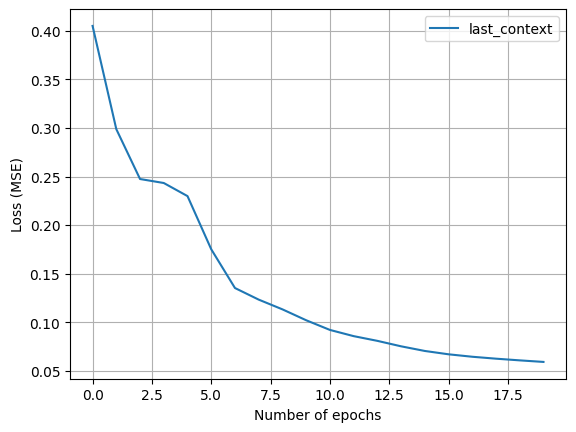

In [36]:
fig, ax = plt.subplots()

for idx, cm in enumerate(context_modes):
    ax.plot(range(flag_params["num_epochs"]), train_losses[cm], color = f"C{idx}", label = cm)
# ax.set_yscale("log")
ax.set_xlabel("Number of epochs")
ax.set_ylabel("Loss (MSE)")
ax.legend()
ax.grid()

# save_path = os.path.join(
#     "../plots/", "koopman_seq2seq/"
# )
# os.makedirs(save_path, exist_ok=True)
# fig.savefig(os.path.join(save_path, "context_mode_comparison.png"), bbox_inches='tight')

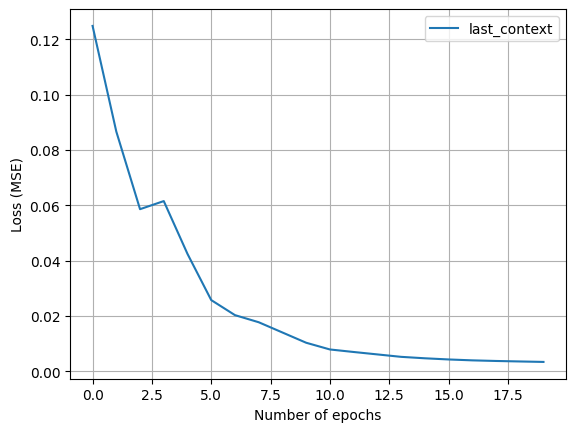

In [37]:
fig, ax = plt.subplots()

for idx, cm in enumerate(context_modes):
    ax.plot(range(flag_params["num_epochs"]), train_losses2[cm], color = f"C{idx}", label = cm)
# ax.set_yscale("log")
ax.set_xlabel("Number of epochs")
ax.set_ylabel("Loss (MSE)")
ax.legend()
ax.grid()

# save_path = os.path.join(
#     "../plots/", "koopman_seq2seq/"
# )
# os.makedirs(save_path, exist_ok=True)
# fig.savefig(os.path.join(save_path, "context_mode_comparison.png"), bbox_inches='tight')

#### Plot predictions

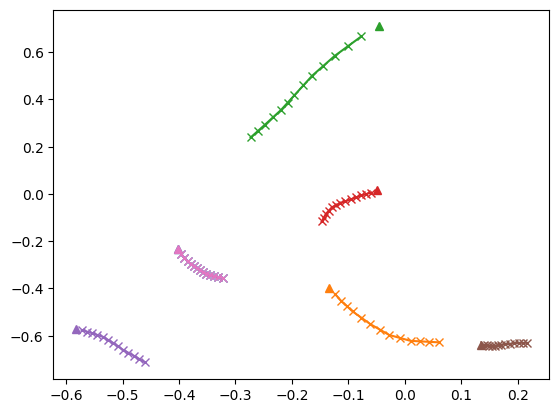

In [29]:
fig, ax = plt.subplots()
for i, idx in enumerate(np.random.randint(0, len(train_set), 7)):
    plot_TCTrackDataset_item_2D(train_set, idx, ax, color=f"C{i}")

torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([3, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([3, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([3, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([3, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([3, 5])


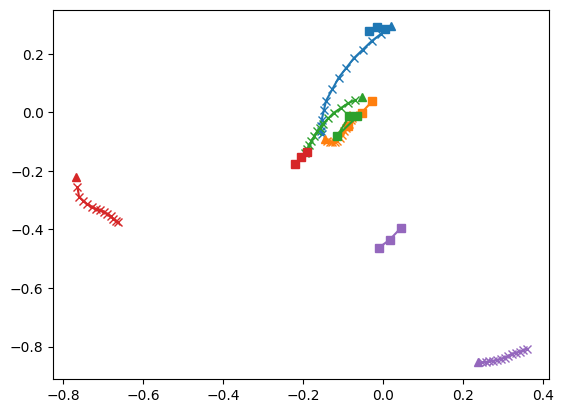

In [30]:
prediction_steps = 3

fig, ax = plt.subplots()
for i, idx in enumerate(np.random.randint(0, len(train_set), 5)):

    plot_TCTrackDataset_item_2D_with_prediction_koopman_seq2seq(
        train_set,
        idx,
        prediction_steps=prediction_steps,
        model=models["full_context"],
        ax=ax,
        color=f"C{i}"
    )

# ax.set_xlim(-1, 1)
# ax.set_ylim(-1, 1)
# ax.set_xlim(-6,-5)
# ax.set_ylim(-9.25,-9)

### Multi step model

In [80]:
flag_params["input_length"] = 13
flag_params["train_output_length"] = 5
flag_params["context_length"] = flag_params["input_length"] + flag_params["train_output_length"]
flag_params["num_epochs"] = 50
# flag_params["koopman_kernel_num_centers"] = 50
flag_params["koopman_kernel_num_centers"] = 1000

In [81]:
tensor_context_train_standardized = standardized_context_dataset_from_TCTracks(
    tc_tracks_train,
    feature_list=feature_list,
    scaler=scaler,
    context_length=flag_params["context_length"],
    time_lag=time_lag,
    fit=True,
    periodic_shift=True,
    basin=basin,
    input_length=flag_params["input_length"],
    output_length=flag_params["train_output_length"],
)

intput_length and output_length are not None.


In [82]:
tensor_context_train_standardized.shape

(3015, 18, 5)

In [ ]:
# rbf = RBFKernel(length_scale=1E-1)

# #TODO some parameters don't play a role in model definition -> remove them
# koopkernelmodel = NystroemKoopKernelSequencer(
#     kernel=rbf,
#     input_dim = num_feats,
#     input_length = flag_params["input_length"],
#     output_length = flag_params["train_output_length"],
#     output_dim = 1,
#     num_steps = 1,
#     num_nys_centers = flag_params["koopman_kernel_num_centers"],
#     rng_seed = 42,
#     # context_mode="last_context"
#     context_mode="no_context"
#     # context_mode="full_context"
# )

# koopkernelmodel._initialize_nystrom_data(tensor_context_train_standardized)

#### Compare context modes

In [85]:
flag_params["train_output_length"]

5

In [ ]:
# context_modes = [
#     "no_context",
#     "full_context",
#     "last_context",
# ]
# models = {}
# train_losses = {}
# for cm in context_modes:
#     m, tl = train_KKSeq2Seq(flag_params["num_epochs"], cm)
#     models[cm] = m
#     train_losses[cm] = tl


rbf = RBFKernel(length_scale=1E-1)

context_mode = "last_context"
# context_mode = "full_context"
# context_mode = "no_context"

koopkernelmodel = NystroemKoopKernelSequencer(
    kernel=rbf,
    input_dim = num_feats,
    input_length = flag_params["input_length"],
    output_length = flag_params["train_output_length"],
    output_dim = 1,
    num_steps = 1,
    num_nys_centers = flag_params["koopman_kernel_num_centers"],
    rng_seed = 42,
    context_mode=context_mode,
)
koopkernelmodel._initialize_nystrom_data(tensor_context_train_standardized)


model, train_loss = train_KKSeq2Seq(
    model=koopkernelmodel,
    eval_metric=eval_metric,
    tc_tracks=tc_tracks,
    num_epochs=flag_params["num_epochs"],
    batch_size=flag_params["batch_size"],
    feature_list=feature_list,
    scaler=scaler,
    basin=basin,
    logger=logger,
    results_dir=results_dir,
    model_name=model_name,
    flag_params=flag_params,
    results_file_name=results_file_name,
    split_valid_set = False,
)

torch.Size([1000, 5]) torch.Size([1000, 5])
range(0, 94)
  batch 10 loss: 0.4492741316556931
  batch 20 loss: 0.2319808378815651
  batch 30 loss: 0.11231947094202041
  batch 40 loss: 0.07032168060541152
  batch 50 loss: 0.0663390163332224
  batch 60 loss: 0.052049097046256064
  batch 70 loss: 0.055054842680692676
  batch 80 loss: 0.0369167847558856
  batch 90 loss: 0.03742564171552658
{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': None, 'initial_lr': 0.001, 'params': [0]}
range(0, 94)
  batch 10 loss: 0.03486640602350235
  batch 20 loss: 0.03213535193353891
  batch 30 loss: 0.02332946062088013
  batch 40 loss: 0.021954132243990898
  batch 50 loss: 0.027205750904977323
  batch 60 loss: 0.025441078934818506
  batch 70 loss: 0.031246060132980348
  batch 80 loss: 0.022924530878663064
  batch 90 loss: 0.028894935548305512
{'lr': 0.0009000000000000001, 'betas': 

In [87]:
train_loss

[0.03742564171552658,
 0.028894935548305512,
 0.026346487738192082,
 0.02542712166905403,
 0.024877582490444184,
 0.0182928285561502,
 0.012673718249425292,
 0.010342279309406876,
 0.008692035917192698,
 0.008351310202851892,
 0.009006814262829722,
 0.012452550837770105,
 0.006446364079602062,
 0.006057468452490866,
 0.0059493490727618335,
 0.005976478941738606,
 0.008881823113188147,
 0.005688745249062777,
 0.006159429065883159,
 0.005144059960730374,
 0.004538535559549928,
 0.0043784511974081395,
 0.004299299069680273,
 0.00417413174873218,
 0.004032243485562503,
 0.003929367510136217,
 0.0038489003316499295,
 0.003754794003907591,
 0.00368600282818079,
 0.003625546267721802,
 0.003566568612586707,
 0.0035117162740789356,
 0.003460326394997537,
 0.003413498983718455,
 0.00337375063681975,
 0.0033386012190021576,
 0.0033034726278856398,
 0.0032682946417480706,
 0.0032346159452572463,
 0.0032045458909124138,
 0.003179080761037767,
 0.0031571053550578654,
 0.003137594787403941,
 0.00311

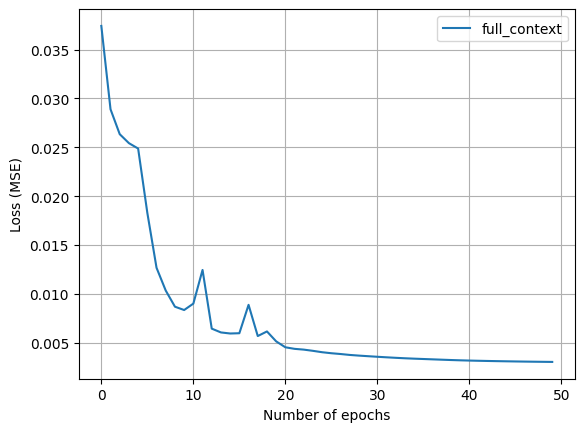

In [88]:
fig, ax = plt.subplots()

ax.plot(range(flag_params["num_epochs"]), train_loss, color = f"C{0}", label = "full_context")
# ax.set_yscale("log")
ax.set_xlabel("Number of epochs")
ax.set_ylabel("Loss (MSE)")
ax.legend()
ax.grid()

# save_path = os.path.join(
#     "../plots/", "koopman_seq2seq/"
# )
# os.makedirs(save_path, exist_ok=True)
# fig.savefig(os.path.join(save_path, "context_mode_comparison.png"), bbox_inches='tight')

#### Plot predictions

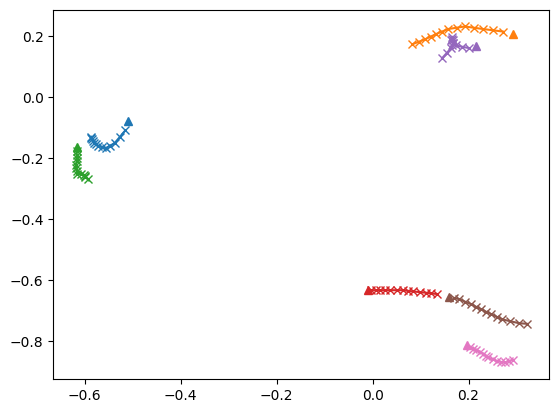

In [71]:
fig, ax = plt.subplots()
for i, idx in enumerate(np.random.randint(0, len(train_set), 7)):
    plot_TCTrackDataset_item_2D(train_set, idx, ax, color=f"C{i}")

torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([10, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([10, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([10, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([10, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([10, 5])


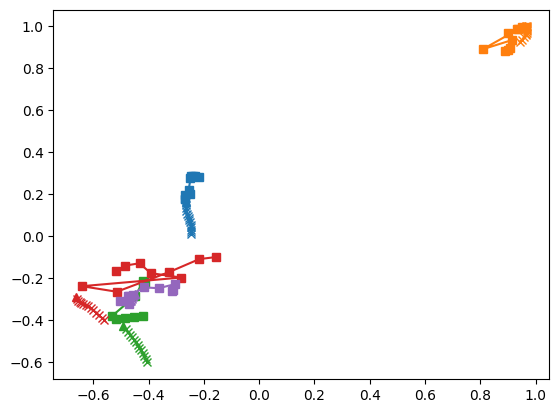

In [78]:
prediction_steps = 10

fig, ax = plt.subplots()
for i, idx in enumerate(np.random.randint(0, len(train_set), 5)):

    plot_TCTrackDataset_item_2D_with_prediction_koopman_seq2seq(
        train_set,
        idx,
        prediction_steps=prediction_steps,
        model=model,
        ax=ax,
        color=f"C{i}"
    )

# ax.set_xlim(-1, 1)
# ax.set_ylim(-1, 1)
# ax.set_xlim(-6,-5)
# ax.set_ylim(-9.25,-9)